<a href="https://colab.research.google.com/github/rrl7012005/Competitions-and-Datasets/blob/main/SVM_vs_CNN_vs_ViT_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Dataset and Visualize

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

train_ds

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
len(train_ds), len(test_ds)


(60000, 10000)

Each element is a tuple of image and label.

0 255
0 255
0 255
0 255
0 255
0 254
0 255
0 255
0 254
0 255
0 255
0 254
0 255
0 255
0 254
0 255


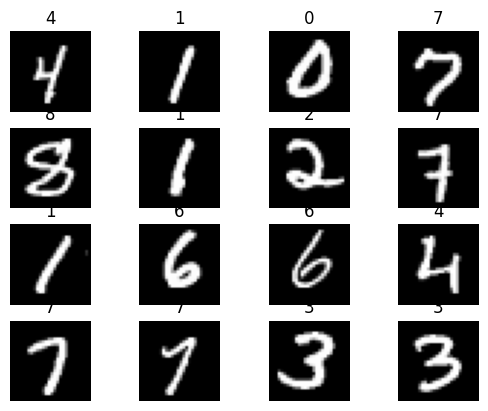

In [ ]:
for i, (image, label) in enumerate(train_ds.take(16)):
  print(image.numpy().min(), image.numpy().max())
  plt.subplot(4, 4, i+1)
  plt.imshow(image.numpy(), cmap='gray')
  plt.title(f'{label}')
  plt.axis('off')

Range is from 0 to 255 so normalize

In [ ]:
def rescale(image, label):
  return tf.cast(image, tf.float32)/255.0, label

In [ ]:
train_ds = train_ds.map(rescale)
test_ds = test_ds.map(rescale)

train_ds = train_ds.shuffle(buffer_size=60000)

train_dataset = train_ds.take(55000)
val_dataset = train_ds.skip(55000)

Now do a dimensionality reduction of each image onto a 2D space for visualization.

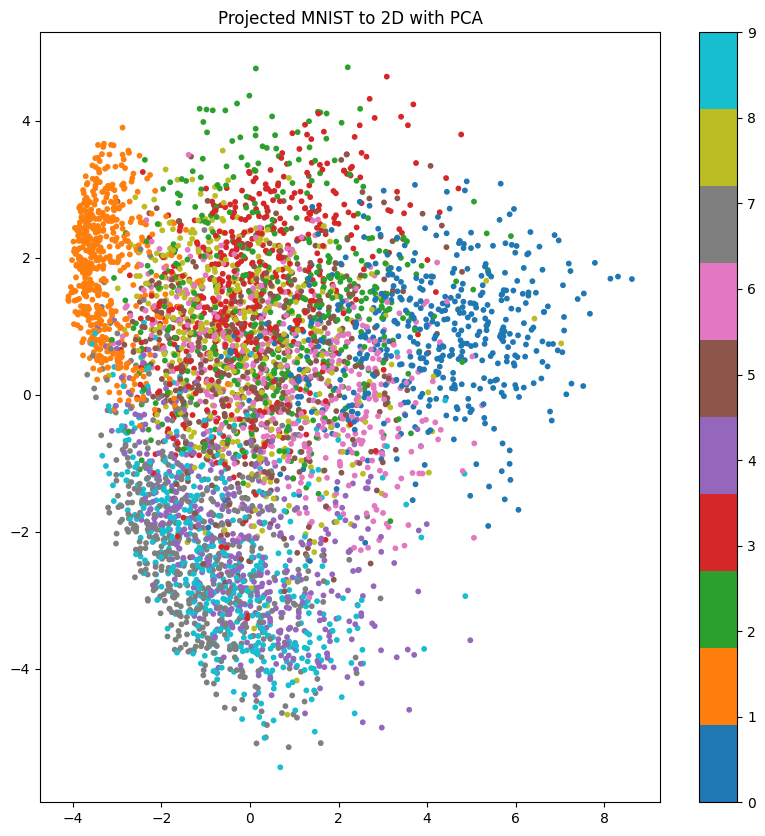

In [ ]:
from sklearn.decomposition import PCA

def flatten(image, label):
  image = tf.reshape(image, (-1,))
  return image, label

train_visual = train_dataset.map(flatten)
train_visual = train_visual.batch(5000)

images, labels = next(iter(train_visual))
flat_images = images.numpy()
labels = labels.numpy()

pca = PCA(n_components=2)

pca.fit(flat_images)

projected_im = pca.transform(flat_images)

plt.figure(figsize=(10, 10))
plt.scatter(projected_im[:, 0], projected_im[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("Projected MNIST to 2D with PCA")
plt.show()

Now try again with t-SNE

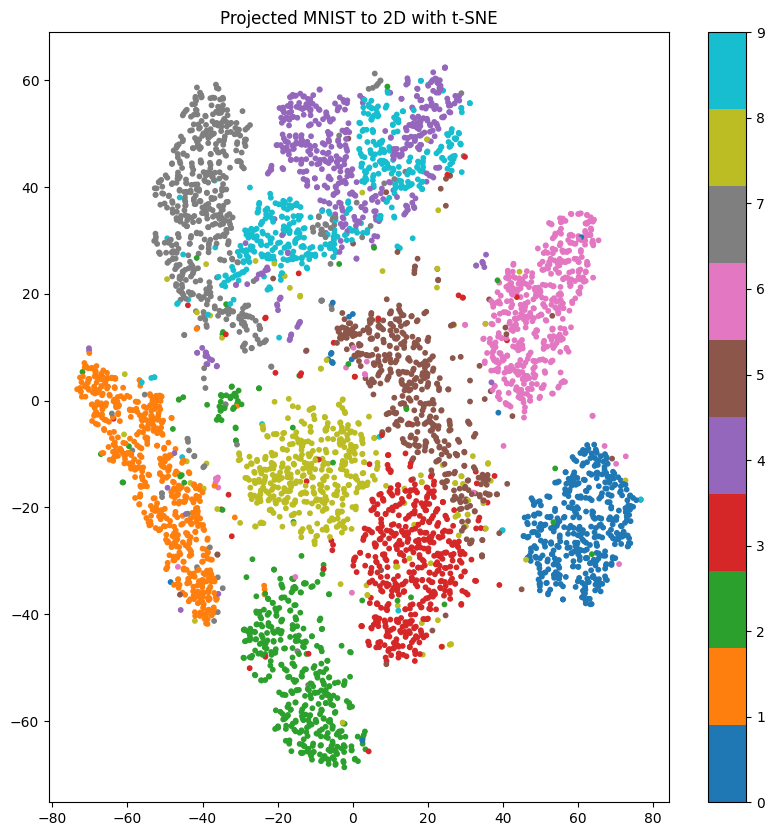

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

projected_im = tsne.fit_transform(flat_images)

plt.figure(figsize=(10, 10))
plt.scatter(projected_im[:, 0], projected_im[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("Projected MNIST to 2D with t-SNE")
plt.show()

Since now we have images and labels, we can do SVM

#SVM

In [ ]:
train_svm = train_dataset.map(flatten).batch(len(train_dataset))
val_svm = val_dataset.map(flatten).batch(len(val_dataset))

images, labels = next(iter(train_svm))
X_train = images.numpy()
y_train = labels.numpy()

images, labels = next(iter(val_svm))
X_val = images.numpy()
y_val = labels.numpy()

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((55000, 784), (55000,), (5000, 784), (5000,))

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_val)

from sklearn.metrics import accuracy_score

val_acc = accuracy_score(y_val, y_pred)
train_acc = accuracy_score(y_train, svm.predict(X_train))

print(f'Train Accuracy: {train_acc}')
print(f'Validation Accuracy: {val_acc}')

Train Accuracy: 0.9712909090909091
Validation Accuracy: 0.9684


Hyperparameter Tune on a much smaller dataset (10,000 datapoints)

In [ ]:
from sklearn.model_selection import GridSearchCV

X_train_tune, y_train_tune = X_train[:5000], y_train[:5000]

param = {
    'C': [0.1, 0.3, 0.5, 1.0, 5.0, 10, 20, 100],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svm, param, cv=3, verbose=3, n_jobs=1)
grid_search.fit(X_train_tune, y_train_tune)

print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV 1/3] END C=0.1, degree=1, gamma=scale, kernel=poly;, score=0.875 total time=   7.6s
[CV 2/3] END C=0.1, degree=1, gamma=scale, kernel=poly;, score=0.887 total time=   4.5s
[CV 3/3] END C=0.1, degree=1, gamma=scale, kernel=poly;, score=0.880 total time=   5.3s
[CV 1/3] END C=0.1, degree=1, gamma=scale, kernel=rbf;, score=0.896 total time=   7.1s
[CV 2/3] END C=0.1, degree=1, gamma=scale, kernel=rbf;, score=0.902 total time=   8.4s
[CV 3/3] END C=0.1, degree=1, gamma=scale, kernel=rbf;, score=0.897 total time=   7.5s
[CV 1/3] END C=0.1, degree=1, gamma=scale, kernel=sigmoid;, score=0.853 total time=   6.8s
[CV 2/3] END C=0.1, degree=1, gamma=scale, kernel=sigmoid;, score=0.849 total time=   5.9s
[CV 3/3] END C=0.1, degree=1, gamma=scale, kernel=sigmoid;, score=0.849 total time=   6.9s
[CV 1/3] END C=0.1, degree=1, gamma=auto, kernel=poly;, score=0.461 total time=   8.2s
[CV 2/3] END C=0.1, degree=1, gamma=auto, kernel=pol

In [ ]:
svm = SVC(kernel='rbf', gamma='scale', C=10)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_val)

from sklearn.metrics import accuracy_score

val_acc = accuracy_score(y_val, y_pred)
train_acc = accuracy_score(y_train, svm.predict(X_train))

print(f'Train Accuracy: {train_acc}')
print(f'Validation Accuracy: {val_acc}')

Train Accuracy: 0.9999090909090909
Validation Accuracy: 0.9986


Now train on both the training and validation sets and test on the training set

In [ ]:
test_svm = test_ds.map(flatten).batch(len(test_ds))

images, labels = next(iter(test_svm))
X_test = images.numpy()
y_test = labels.numpy()

X_test.shape, y_test.shape

((10000, 784), (10000,))

In [ ]:
svm = SVC(kernel='rbf', gamma='scale', C=10)

X = np.concatenate([X_train, X_val], axis=0)
y = np.concatenate([y_train, y_val], axis=0)

svm.fit(X, y)

y_pred = svm.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y, svm.predict(X))

Train Accuracy: 0.9999166666666667


NameError: name 'val_acc' is not defined

In [ ]:
print(f'Train Accuracy: {train_acc}')
print(f'Validation Accuracy: {test_acc}')

Train Accuracy: 0.9999166666666667
Validation Accuracy: 0.9836


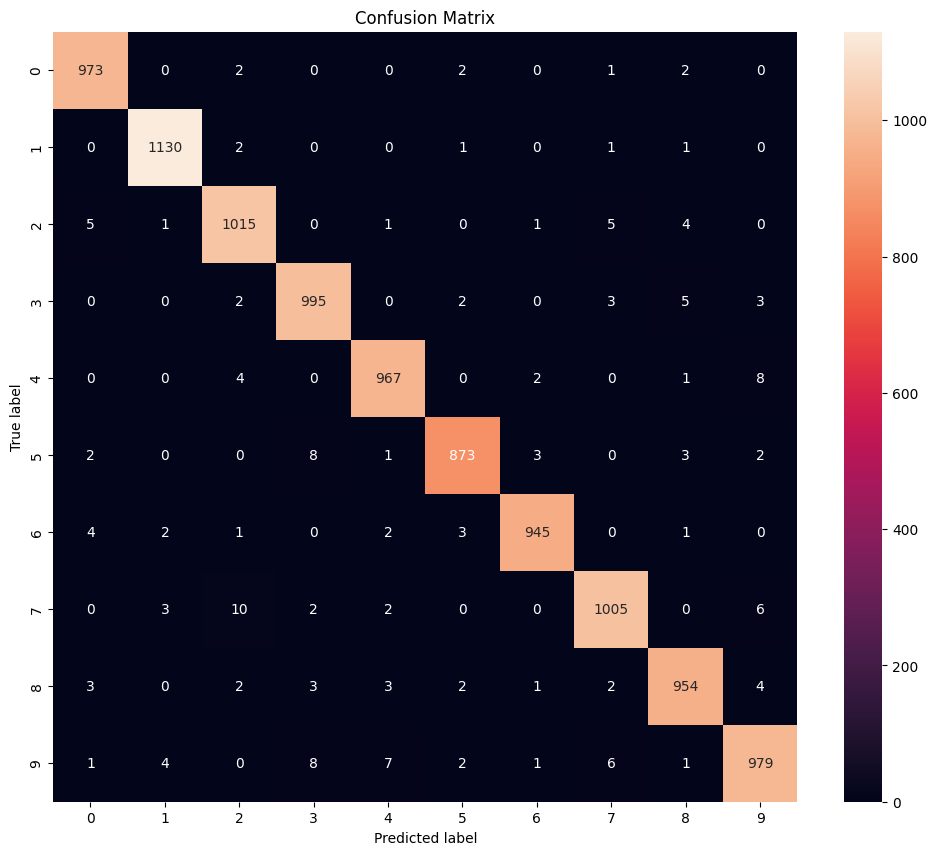

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

FINAL RESULT:

-Training accuracy: 99.99%
-Testing accuracy: 98.4%

#CNN

In [ ]:
batch_size = 32

train_dataset = train_ds.take(55000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = train_ds.skip(55000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

len(train_dataset), len(val_dataset), len(test_dataset)

(1719, 157, 313)

Now build the model

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
model0 = tf.keras.Sequential([
    InputLayer(input_shape=(28, 28, 1)),

    Conv2D(filters=24, kernel_size=3, strides=1, padding='valid', activation='relu'),
    Conv2D(filters=48, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.2),

    Conv2D(filters=48, kernel_size=3, strides=1, padding='valid', activation='relu'),
    Conv2D(filters=24, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(0.2),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model0.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 26, 26, 24)          │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 24, 24, 48)          │          10,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 10, 10, 48)          │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 8, 8, 24)            │          10,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 24)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │          38,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,342 (317.74 KB)

 Trainable params: 81,342 (317.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model0.compile(optimizer='Adam', learning_rate=1e-3, loss=loss_fn, metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2,
                            verbose=1, mode='auto', baseline=None, restore_best_weights=True)

lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                                verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks = [es_callback, lr_callback]

history = model0.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks=callbacks)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.8218 - loss: 0.5302 - val_accuracy: 0.9836 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9725 - loss: 0.0913 - val_accuracy: 0.9872 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9781 - loss: 0.0713 - val_accuracy: 0.9936 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9824 - loss: 0.0574 - val_accuracy: 0.9940 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9847 - loss: 0.0493 - val_accuracy: 0.9958 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9855 - loss: 0.0468 - val_accuracy: 0.9942 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.98

In [ ]:
model0.evaluate(test_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9937 - loss: 0.0197


[0.019273269921541214, 0.9944999814033508]

CNN achieved 99.4% accuracy with a negative log likelihood of 0.02.

#Vision Transformers